In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install faiss-gpu-cu11

In [3]:
import os, json
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as T
from tqdm import tqdm
import faiss
import matplotlib.pyplot as plt
import cv2
from transformers import AutoModel, AutoImageProcessor

In [4]:
def load_oxford_ground_truth(gt_dir):
    gt_dict = {}

    for file in os.listdir(gt_dir):
        if not file.endswith('_query.txt'):
            continue

        base = file.replace('_query.txt', '')
        #oxc1_all_souls_000013 136.5 34.1 648.5 955.7
        with open(os.path.join(gt_dir, file), 'r') as f:
            query_line = f.readline().strip()
            query_name = query_line.split()[0].replace('oxc1_', '') + ".jpg"

        relevant = []
        for suffix in ['_good.txt', '_ok.txt']:
            path = os.path.join(gt_dir, base + suffix)
            if os.path.exists(path):
                with open(path, 'r') as f:
                    relevant += [line.strip() + ".jpg" for line in f if line.strip()]

        gt_dict[query_name] = relevant
    return gt_dict


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:::", device)

Device::: cuda


In [6]:
DATA_PATH = '/content/drive/MyDrive/dinov2/'
FAISS_INDEX_PATH = os.path.join(DATA_PATH, 'core/oxford_index.bin')
EMBEDDINGS_JSON_PATH = os.path.join(DATA_PATH, 'core/oxford_embeddings.json')

IMAGE_COLLECTION_PATH = f"{DATA_PATH}collection/images"
GROUND_TRUTH_PATH = f"{DATA_PATH}collection/gtruth/"

In [7]:
# Load FAISS index
index = faiss.read_index(FAISS_INDEX_PATH)

# Load embedding JSON (dùng để mapping index → tên file ảnh)
with open(EMBEDDINGS_JSON_PATH, 'r') as f:
    all_embeddings = json.load(f)

# Lấy danh sách file ảnh theo thứ tự index đã add
files = list(all_embeddings.keys())

In [8]:
# Transform giống như lúc tạo index
transform = T.Compose([
    T.ToTensor(),
    T.Resize(244),
    T.CenterCrop(224),
    T.Normalize([0.5], [0.5])
])

In [9]:
def load_query_image_from_txt(query_txt_path, images_dir):
    with open(query_txt_path, 'r') as f:
        line = f.readline().strip()
        parts = line.split()
        image_base = parts[0].replace('oxc1_', '') + '.jpg'
        x1, y1, x2, y2 = map(float, parts[1:])

    image_path = os.path.join(images_dir, image_base)
    image = Image.open(image_path).convert('RGB')
    cropped = image.crop((x1, y1, x2, y2))

    return transform(cropped).unsqueeze(0).to(device), image_base

In [10]:
dinov2_model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base', use_fast=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:

gt_dict = load_oxford_ground_truth(GROUND_TRUTH_PATH)
retrieved_results = {}

for query_file in tqdm(os.listdir(GROUND_TRUTH_PATH)):
    if not query_file.endswith("_query.txt"):
        continue

    query_path = os.path.join(GROUND_TRUTH_PATH, query_file)
    query_tensor, query_img_name = load_query_image_from_txt(query_path, IMAGE_COLLECTION_PATH)

    with torch.no_grad():
        out = dinov2_model(query_tensor)
        query_embedding = out.pooler_output.cpu().numpy()

    D, I = index.search(query_embedding, k=5)
    retrieved = [files[idx] for idx in I[0]]
    retrieved_results[query_img_name] = retrieved

100%|██████████| 220/220 [00:05<00:00, 40.32it/s]


In [12]:
def apk(actual, predicted, k=5):
    if not actual:
        return 0.0
    predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k)

def mapk(gt_dict, retrieved_dict, k=5):
    scores = []
    for query_img in gt_dict:
        actual = gt_dict[query_img]
        predicted = retrieved_dict.get(query_img, [])
        scores.append(apk(actual, predicted, k))
    return np.mean(scores)

def precision_at_k(actual, predicted, k):
    if not actual:
        return 0.0
    predicted = predicted[:k]
    hits = sum([1 for p in predicted if p in actual])
    return hits / k


In [13]:
def evaluate_metrics(gt_dict, retrieved_dict, k):
    apk_scores = []
    precision_scores = []

    for query_img in gt_dict:
        actual = gt_dict[query_img]
        predicted = retrieved_dict.get(query_img, [])[:k]

        precision = precision_at_k(actual, predicted, k)
        ap = apk(actual, predicted, k)

        apk_scores.append(ap)
        precision_scores.append(precision)

    return np.mean(apk_scores), np.mean(precision_scores)


k = 5: MAP@5 = 0.8115, Precision@5 = 0.8473
k = 10: MAP@10 = 0.4453, Precision@10 = 0.4236
k = 15: MAP@15 = 0.3479, Precision@15 = 0.2824
k = 20: MAP@20 = 0.3031, Precision@20 = 0.2118


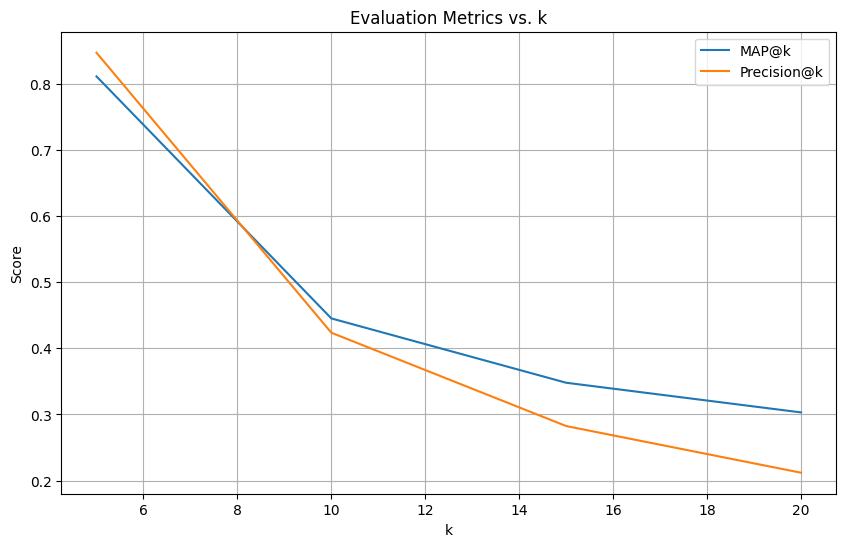

In [14]:
k_list = [5, 10, 15, 20]
map_list = []
precision_list = []

for k in k_list:
    score, precision = evaluate_metrics(gt_dict, retrieved_results, k)

    print(f"k = {k}: MAP@{k} = {score:.4f}, Precision@{k} = {precision:.4f}")
    map_list.append(score)
    precision_list.append(precision)

plt.figure(figsize=(10, 6))
plt.plot(k_list, map_list, label='MAP@k')
plt.plot(k_list, precision_list, label='Precision@k')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. k')
plt.legend()
plt.grid(True)
plt.show()
